<a href="https://colab.research.google.com/github/diwu437/diwu-github.io/blob/master/%E2%80%9CAmazon_prime_Movie_View_Time_Predication_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0 Load packages, load data


In [0]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import files
uploaded = files.upload()

Saving TVdata.txt to TVdata.txt


In [0]:
TV=pd.read_table('TVdata.txt',header=0,sep=',',lineterminator='\n')
print(TV.head())

# Part 1: Data Exploration

## 1.1 Exclude erroneous data

Each video should only appear once in the list, duplicated video will be removed.

In [4]:
# Remove duplicate observations
if TV.set_index('video_id').index.duplicated().sum()==0:
  print('no duplicated index')
  

no duplicated index


## 1.2 Understand numerical features

### 1.2.1 Overview

In [0]:
# Checking percentiles for numberic varibles
TV.info()
print(TV.drop(columns=['video_id','release_year'],axis=1).describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))


In [85]:
TV.head(5)

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


### 1.2.2 cvt_per_day feature

In [0]:
plt.hist(TV['cvt_per_day'],bins=range(0,15000,30),color='r',label='cvt_per_day',density=True,alpha=0.5)
plt.title('Historgrams of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

### 1.2.3 Correlation among numerical features

In [0]:
corr = TV[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [0]:
corr

## 1.3 Understand categorical features

### 1.3.1 Distribution of standard categorical features

In [0]:
sns.stripplot(x='import_id', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['import_id'].value_counts())

sns.stripplot(x='mpaa', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['mpaa'].value_counts())

sns.stripplot(x='awards', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print(TV['awards'].value_counts())

### 1.3.2 Distribution of splited genres

Some videos belongs to more than 1 genre, the genre of each video is splited, this would help emphasize the effect of each individual genre.

In [0]:
# generes explore, split the genre of each video
gen_split = TV['genres'].str.get_dummies(sep=',').sum()
print(gen_split)
# return numbers of each genre
gen_split.sort_values(ascending=False).plot.bar()

### 1.3.3 Distribution of release_year

The release year of video varies through a wide range. Considering the popularity of a video usually decays over time, the release_year should be bucketed based on the release_year range.

In [0]:
plt.hist(TV['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='r', label = 'release_year', normed = True)
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()


# Part 2: Feature Preprocessing

## 2.1 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). I will group those 6 varibles into one group. Note: a video may have more than one genre, in the feature preprocessing, all genres are handled individually.

The release_year is bined into 10 buckets based on the year range between 1917 and 2017.

In [0]:
# Convert 3 Categorical variables into dummy variables
d_import_id = pd.get_dummies(TV['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(TV['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(TV['awards']).astype(np.int64)

In [0]:
# Convert 'genres' into dummy variables
d_genres=TV['genres'].str.get_dummies(sep=',').astype(np.int64)
d_genres['Misc_genres']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [0]:

TV['release_year'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

In [0]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(TV['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [0]:
# new dataframe, drop the previous categorical features, add new dummy variables, check for null

temp_tv=TV.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)

newTV = pd.concat([temp_tv, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
newTV.head(2)

## 2.2 Missing data

Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

There are 3242 samples have at least one missing data.


For those missing values that are represented by 0, i would also check the ratio of them. 

In [0]:
newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)
print(newTV.info())
print(newTV.isnull().sum()/newTV.shape[0])


In [0]:
# For null value, i replace them with the mean value
newTV1=newTV.copy()
newTV1['boxoffice']=newTV1['boxoffice'].fillna(newTV1['boxoffice'].mean())
newTV1['metacritic_score']=newTV1['metacritic_score'].fillna(newTV1['metacritic_score'].mean())
newTV1['star_category']=newTV1['star_category'].fillna(newTV1['star_category'].mean())
newTV1['imdb_votes']=newTV1['imdb_votes'].fillna(newTV1['imdb_votes'].mean())
newTV1['imdb_rating']=newTV1['imdb_rating'].fillna(newTV1['imdb_rating'].mean())
newTV1['budget']=newTV1['budget'].fillna(newTV1['budget'].mean())
print(newTV1.info())

## 2.3 Feature scaling

In [0]:
#I used stand scaling to transfer varibles in order to enhance model perfermance
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
newTV_sc = newTV1.copy()

sc_scale = StandardScaler().fit(newTV_sc[scale_lst])
newTV_sc[scale_lst] = sc_scale.transform(newTV_sc[scale_lst])

newTV_sc.head()


# Part 3: Model Training

In [0]:
model_train, model_test = train_test_split(newTV_sc, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = model_test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = model_train['cvt_per_day']
model_test_y = model_test['cvt_per_day']

### 3.1 Lasso linear regression

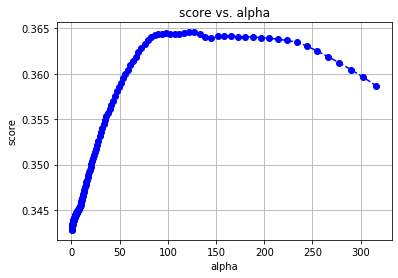

The optimaized alpha and score of Lasso linear is: 


(None, 122.06107238906554, 0.36457853302954246)

In [66]:
# I first start with lasso linear regression, and i used a for loop to find the best alpha and its R-square score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.logspace (-0.3, 2.5, num=150)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score


In [65]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19655734268.973633, tolerance: 54965082.96651766
  positive)


Lasso(alpha=0.06610787002555378, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## 3.3 Ridge linear regression

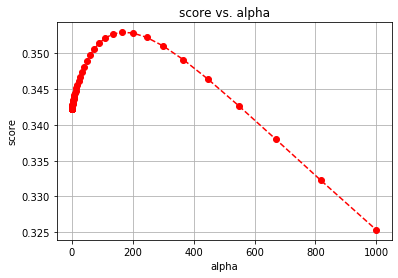

The optimaized alpha and score of Ridge linear is: 


(None, 163.97026580002054, 0.35296043098491625)

In [68]:
# Here i used the same training data set as Lasso and select the model with the best alpha 
lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

alphas = np.logspace (-10, 3, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [69]:
# add the 15% validate data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the Ridge model (linear feature), to be tested with test data.

Ridge(alpha=163.97026580002054, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

##3.5 Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf=RandomForestRegressor(random_state=2,max_features='sqrt',n_jobs=-1)
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,refit=True,n_jobs=-1,pre_dispatch='2*n_jobs')
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

{'mean_fit_time': array([0.39415603, 0.37472916, 0.40624995, 0.44193115, 0.42466698,
       0.44389224, 0.42986164, 0.4221324 , 0.42900877, 0.42179594,
       0.44459429, 0.42330575, 0.37505307, 0.42663565, 0.42491703,
       0.4431201 , 0.4252851 , 0.44362149, 0.43492599, 0.42654219,
       0.44498405, 0.44479203, 0.40139666, 0.44009495, 0.42713809,
       0.44210405, 0.42561212, 0.42510719, 0.4445035 , 0.44785385,
       0.46117454, 0.4394691 , 0.48997035, 0.47358603, 0.42015786,
       0.45490479, 0.42263422, 0.45083761, 0.44139791, 0.45419645,
       0.45822678, 0.47870245, 0.46126127, 0.48168335, 0.42589521,
       0.42725081, 0.43756609, 0.43033924, 0.45115967, 0.45275402,
       0.45700703, 0.49951386, 0.51849351, 0.5465765 , 0.55503793,
       0.4296454 , 0.42891212, 0.44807858, 0.45811095, 0.46728244,
       0.45361743, 0.47079873, 0.53441086, 0.52754421, 0.54729981,
       0.53287973, 0.41611686, 0.45497837, 0.45534902, 0.53200169,
       0.55070596, 0.5414484 , 0.52831659, 0

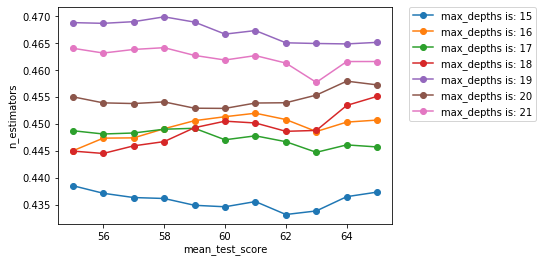

the best parameter for max_depth is: 19
the best parameter for n_estimators is: 58


In [72]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]
n_estimators=[55,56,57,58,59,60,61,62,63,64,65]
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('mean_test_score')
plt.ylabel('n_estimators')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))



# Part 4: Model Evaluation

## 4.1: Evaluate all models

In [77]:
#For lasso, the optimal alpha is 107.20161850474553
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=107.20161850474553)
lasso.fit(model_train_x,model_train_y)
model_pred_y=lasso.predict(model_test_x)
lasso_score=lasso.score(model_test_x,model_test_y)
MSE_lasso=mean_squared_error(model_test_y,model_pred_y)

print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)


lasso score:  0.10167520895097015
Mean square error of lasso:  238389030.67935738
Root mean squared error of lasso: 15439.852029062888


In [78]:
#for ridge,the optimal alpha is 200.453398090524
from sklearn.linear_model import Ridge
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=200.453398090524)
ridge.fit(model_train_x,model_train_y)
pred_y=ridge.predict(model_test_x)
ridge_score=ridge.score(model_test_x,model_test_y)
MSE_ridge=mean_squared_error(model_test_y,pred_y)

print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)


ridge score:  0.11419607776136165
Mean square error of ridge:  235066359.62684524
Root mean squared error of ridge: 15331.873976355442


In [79]:
#For randomforest regression, the optimal n_estimators is 64 , the optimal max_depth is 17
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=64,max_depth=17,max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(model_train_x,model_train_y)
pred_y=rf.predict(model_test_x)
rf_score=rf.score(model_test_x,model_test_y)
MSE_rf=mean_squared_error(model_test_y,pred_y)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)



rf score:  0.5532465652599368
Mean square error of rf:  118555247.85861608
Root mean squared error of rf: 10888.307851021484


## 4.2 Model comparison 

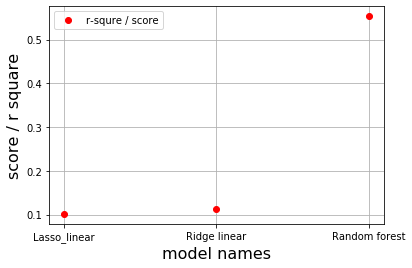

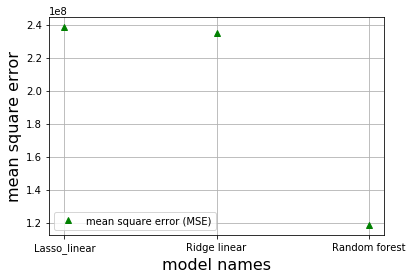

In [83]:
lst_score = [lasso_score,ridge_score,rf_score]
MSE_lst =  [MSE_lasso,MSE_ridge,MSE_rf]
model_lst = ['Lasso_linear','Ridge linear', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()


## 4.3 Feature importance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


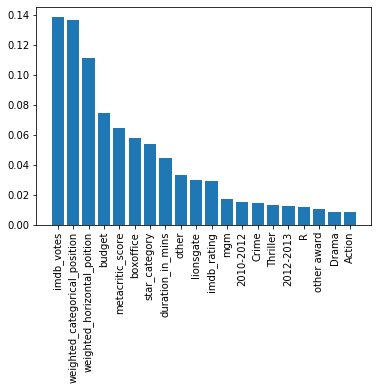

In [84]:
# According to MSE,and R square, I found Random Forest Regression has the best performance
# In the following, i will plot the feature importance from random forest model
# I found votes, position and budget are the top three important factors on Movie view time

importances = rf.feature_importances_
feature_name = model_train_x.columns.get_values()
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()